# Проект 4. Итоговый вызов

# Описание проекта

Необходимо по в хакатоне на kaggle: https://www.kaggle.com/c/sf-dst-scoring

# Описания полей датасета:

- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту

# Загрузка библиотек

In [174]:
from pandas import Series
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, f1_score, log_loss
from sklearn.metrics import accuracy_score, recall_score, precision_score

from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

# Функции

In [175]:
def get_outliners(data):
    '''
    Определяем выбросы
    '''
    median = data.median()
    quan25 = data.quantile(0.25)
    quan75 = data.quantile(0.75)
    IQR = quan75 - quan25
    left = quan25 - 1.5*IQR,
    right = quan75 + 1.5*IQR
    return left, right

# Загрузка данных

In [176]:
train = pd.read_csv('train-bank.csv')
test = pd.read_csv('test-bank.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [177]:
train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [178]:
test.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


In [179]:
sample_submission.head()

,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501
4,4264,0.304640


In [180]:
train['sample'] = 1  # помечаем где у нас трейн
test['sample'] = 0  # помечаем где у нас тест
# в тесте у нас нет значения default, мы его должны предсказать, поэтому пока просто заполняем нулями
test['default'] = -1

df = train.append(test, sort=False).reset_index(drop=True)  # объединяем

In [181]:
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,1
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,1
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0,1
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0,1
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0,1


In [182]:
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,1
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,1
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0,1
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0,1
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0,1


In [183]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

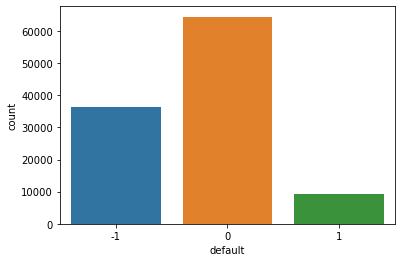

In [184]:
ax = sns.countplot(x='default', data=df)

In [185]:
df.default.value_counts()

 0    64427
-1    36349
 1     9372
Name: default, dtype: int64

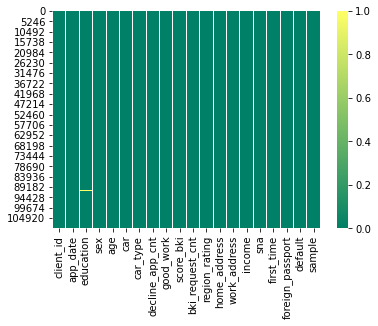

In [186]:
sns.heatmap(df.isnull(), cmap='summer')

In [187]:
df.isnull().sum()

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
sample                0
dtype: int64

In [188]:
df.education.value_counts()

SCH    57998
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

In [189]:
df['education'].fillna(df.education.value_counts().index[0], inplace=True)

In [190]:
# преобразуем столбец с датой
df['app_date'] = pd.to_datetime(df['app_date'])
curr_date = pd.to_datetime('28MAR2021')
df['app_date'] = (curr_date - df.app_date).dt.days
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample
0,25905,2612,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,1
1,63161,2573,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,1
2,25887,2612,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0,1
3,16222,2621,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0,1
4,101655,2536,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0,1


In [191]:
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
cat_cols = ['education', 'home_address', 'work_address', 'sna', 'first_time', 'region_rating']
num_cols = ['age', 'decline_app_cnt', 'income',
            'bki_request_cnt', 'score_bki', 'app_date']
sample = ['sample']

In [192]:
# убираем выбросы в численных столбцах
for col in ['bki_request_cnt', 'score_bki']:
    left, right = get_outliners(df[df['sample'] == 1][col])
    df.drop(df[(df['sample'] == 1) & ((df[col] < left) | (df[col] > right))].index, inplace=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ffaa0518520>,
      dtype=object)

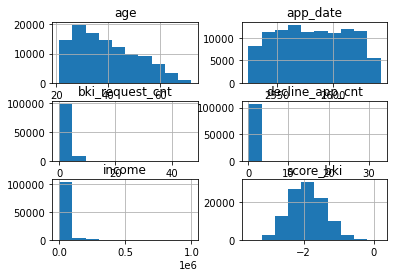

In [193]:
df[num_cols].hist()

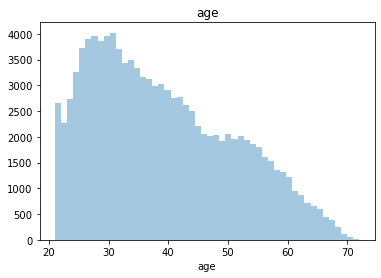

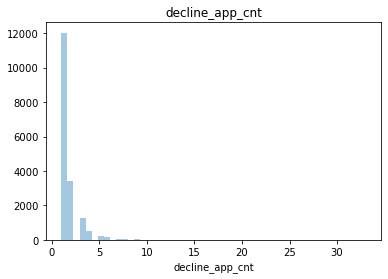

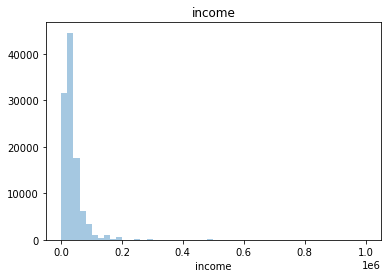

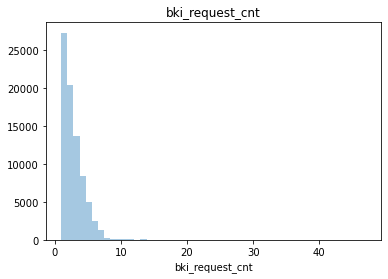

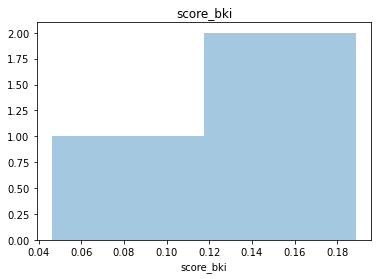

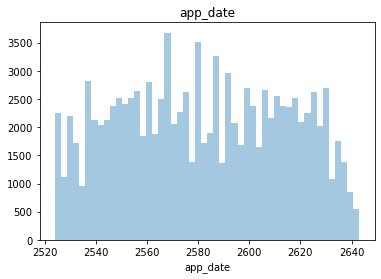

In [194]:
for i in num_cols:
    plt.figure()
    sns.distplot(df[i][df[i] > 0].dropna(), kde=False, rug=False)
    plt.title(i)
    plt.show()

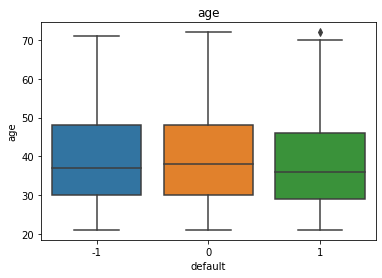

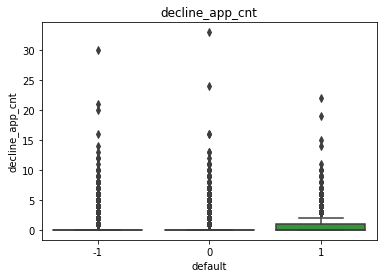

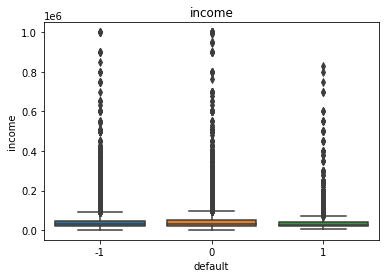

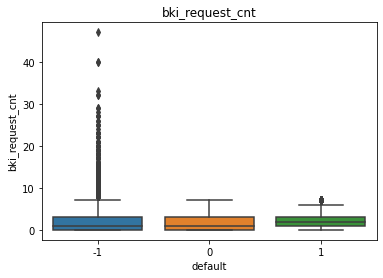

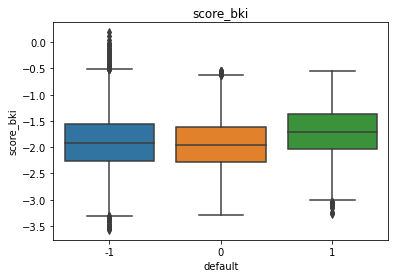

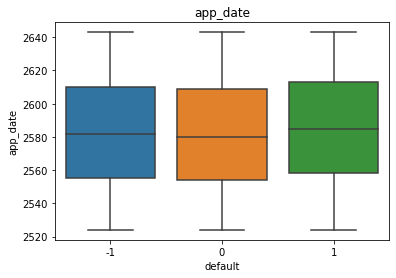

In [195]:
for i in num_cols:
    plt.figure()
    sns.boxplot(x=df['default'], y=df[i])
    plt.title(i)
    plt.show()

Прологарифмируем смещенные переменные

In [196]:
for col in ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']:
    df[col] = np.log(df[col] + 1)

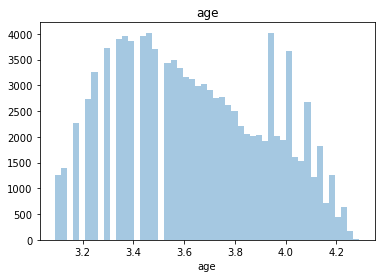

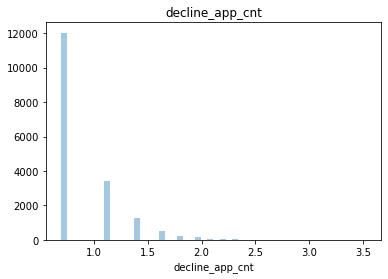

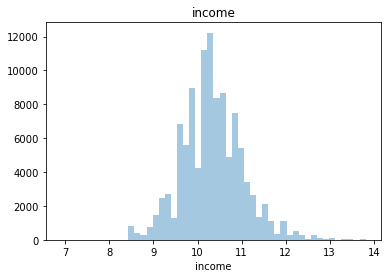

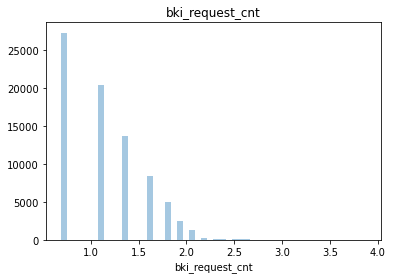

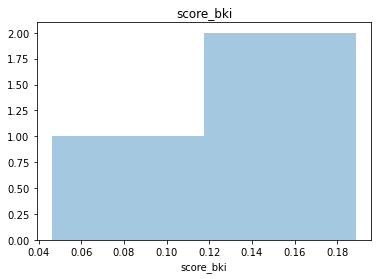

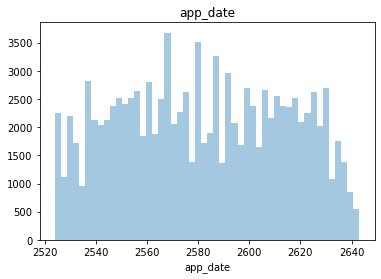

In [197]:
for i in num_cols:
    plt.figure()
    sns.distplot(df[i][df[i] > 0].dropna(), kde=False, rug=False)
    plt.title(i)
    plt.show()

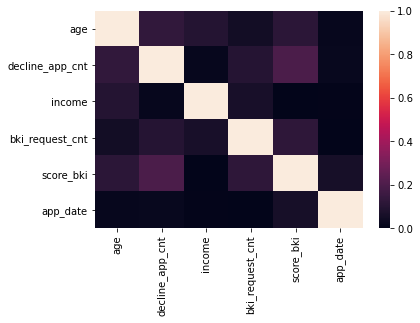

In [198]:
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1)

In [199]:
df[num_cols].corr()

,age,decline_app_cnt,income,bki_request_cnt,score_bki,app_date
age,1.000000,-0.131207,-0.094099,0.047069,-0.113776,-0.018400
decline_app_cnt,-0.131207,1.000000,-0.018259,0.098411,0.197117,0.019532
income,-0.094099,-0.018259,1.000000,0.062541,-0.002175,-0.003914
bki_request_cnt,0.047069,0.098411,0.062541,1.000000,0.124163,0.000932
score_bki,-0.113776,0.197117,-0.002175,0.124163,1.000000,0.059253
app_date,-0.018400,0.019532,-0.003914,0.000932,0.059253,1.000000


In [200]:
df.corr()

,client_id,app_date,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default,sample
client_id,1.000000,-0.999581,0.018102,-0.019567,0.003516,-0.058961,-0.000846,0.006200,0.164377,0.164316,0.004328,-0.001980,0.017923,-0.008803,0.005628
app_date,-0.999581,1.000000,-0.018400,0.019532,-0.003388,0.059253,0.000932,-0.005117,-0.162995,-0.162654,-0.003914,0.001817,-0.017547,0.008840,-0.005635
age,0.018102,-0.018400,1.000000,-0.131207,-0.069798,-0.113776,0.047069,-0.091997,0.001895,-0.013974,-0.094099,-0.068998,0.093913,-0.008678,0.002143
decline_app_cnt,-0.019567,0.019532,-0.131207,1.000000,-0.034849,0.197117,0.098411,-0.043146,0.011203,0.017284,-0.018259,0.069259,-0.080617,0.036553,-0.006893
good_work,0.003516,-0.003388,-0.069798,-0.034849,1.000000,0.004878,0.007537,0.070407,-0.009355,-0.012359,0.053054,-0.053130,0.059315,-0.018476,-0.002670
score_bki,-0.058961,0.059253,-0.113776,0.197117,0.004878,1.000000,0.124163,0.006110,0.015710,0.016786,-0.002175,0.067767,-0.070457,0.049571,-0.012386
bki_request_cnt,-0.000846,0.000932,0.047069,0.098411,0.007537,0.124163,1.000000,-0.025149,-0.001185,-0.005847,0.062541,0.011748,0.005775,-0.003172,-0.030272
region_rating,0.006200,-0.005117,-0.091997,-0.043146,0.070407,0.006110,-0.025149,1.000000,0.232001,0.253503,0.311904,-0.080955,0.091077,-0.037708,-0.005635
home_address,0.164377,-0.162995,0.001895,0.011203,-0.009355,0.015710,-0.001185,0.232001,1.000000,0.726285,0.044159,0.114635,-0.058675,0.031794,0.000703
work_address,0.164316,-0.162654,-0.013974,0.017284,-0.012359,0.016786,-0.005847,0.253503,0.726285,1.000000,0.068236,0.111228,-0.062386,0.026045,-0.004290


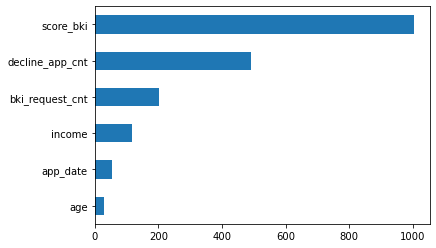

In [201]:
imp_num = Series(f_classif(df[num_cols], df['default'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

In [202]:
label_encoder = LabelEncoder()

mapped_education = pd.Series(label_encoder.fit_transform(df['sex']))
print(dict(enumerate(label_encoder.classes_)))

{0: 'F', 1: 'M'}


In [203]:
# Для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])

# убедимся в преобразовании
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample
0,25905,2612,SCH,1,4.143135,1,1,0.000000,0,-2.008753,0.693147,50,1,2,9.798183,4,1,0,0,1
1,63161,2573,SCH,0,4.094345,0,0,0.000000,0,-1.532276,1.386294,50,2,3,9.852247,4,1,0,0,1
2,25887,2612,SCH,1,3.258097,1,0,1.098612,0,-1.408142,0.693147,80,1,2,10.308986,1,4,1,0,1
3,16222,2621,SCH,0,3.988984,0,0,0.000000,0,-2.057471,1.098612,50,2,3,9.210440,1,3,0,0,1
4,101655,2536,GRD,1,3.891820,0,0,0.000000,1,-1.244723,0.693147,60,2,3,10.308986,1,4,1,0,1


In [204]:
df['education'] = label_encoder.fit_transform(df['education'])

In [205]:
X_cat_train = OneHotEncoder(sparse=False).fit_transform(
    df[cat_cols+sample].query('sample == 1').drop(['sample'], axis=1).values)
X_cat_test = OneHotEncoder(sparse=False).fit_transform(
    df[cat_cols+sample].query('sample == 0').drop(['sample'], axis=1).values)
X_cat_train.shape, X_cat_test.shape

((71718, 26), (36349, 26))

In [206]:
# Стандартизация числовых переменных
X_num_train = StandardScaler().fit_transform(
    df[num_cols+sample].query('sample == 1').drop(['sample'], axis=1).values)
X_num_test = StandardScaler().fit_transform(
    df[num_cols+sample].query('sample == 0').drop(['sample'], axis=1).values)
X_num_train.shape, X_num_test.shape

((71718, 6), (36349, 6))

In [207]:
X_bin_train = df[bin_cols +
                 sample].query('sample == 1').drop(['sample'], axis=1).values
X_bin_test = df[bin_cols +
                sample].query('sample == 0').drop(['sample'], axis=1).values
X_bin_train.shape, X_bin_test.shape

((71718, 5), (36349, 5))

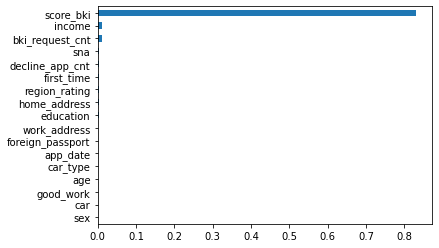

In [208]:
imp_cat = Series(mutual_info_classif(df[bin_cols + cat_cols + num_cols], df['default'],
                                     discrete_features=True), index=bin_cols + cat_cols + num_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

In [209]:
# Объединяем
X = np.hstack([X_num_train, X_bin_train, X_cat_train])
y = df[['default', 'sample']].query(
    'sample == 1').drop(['sample'], axis=1).values
X_test = np.hstack([X_num_test, X_bin_test, X_cat_test])
X.shape, y.shape, X_test.shape

((71718, 37), (71718, 1), (36349, 37))

In [210]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.20, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((57374, 37), (14344, 37), (57374, 1), (14344, 1))

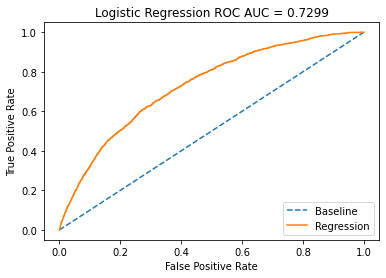

In [211]:
model = LogisticRegression()
model.fit(X_train, y_train)

probs = model.predict_proba(X_valid)
probs = probs[:, 1]

y_pred = model.predict(X_valid)

fpr, tpr, threshold = roc_curve(y_valid, probs)
roc_auc = roc_auc_score(y_valid, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.4f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [212]:
print(accuracy_score(y_valid, y_pred))
print(f1_score(y_valid, y_pred))

0.8743028443948689
0.03427959292983396


In [213]:
# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 1.0


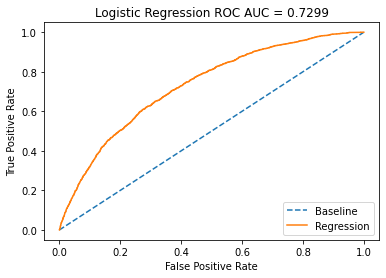

In [214]:
model = LogisticRegression(penalty=best_model.best_estimator_.get_params()['penalty'],
                           C=best_model.best_estimator_.get_params()['C'], max_iter=1000)
model.fit(X_train, y_train)

probs = model.predict_proba(X_valid)
probs = probs[:, 1]

fpr, tpr, threshold = roc_curve(y_valid, probs)
roc_auc = roc_auc_score(y_valid, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.4f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [215]:
print(accuracy_score(y_valid, y_pred))
print(f1_score(y_valid, y_pred.T))

0.8743028443948689
0.03427959292983396


In [216]:
probs = model.predict_proba(X_test)
probs = probs[:, 1]

In [217]:
submit = pd.DataFrame({'client_id': test.client_id,
                       'default': probs})
submit.to_csv('submission.csv', index=False)

In [218]:
df['region_rating'].value_counts()

50    40290
60    23565
40    17689
80    16740
70     9045
30      429
20      309
Name: region_rating, dtype: int64